In [0]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D, Activation, Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from google.colab import files, drive
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import numpy as np
import os
import io
import zipfile
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
#drive.mount('/content/gdrive', force_remount=True)
#root_path = 'gdrive/My Drive/tabOCR/'

In [0]:
#data = zipfile.ZipFile(root_path + "dataset/tictactoe.zip", 'r')
#data.extractall()

In [0]:
uploaded = files.upload()
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_columns.zip']), 'r')
data.extractall()

Saving dataset_columns.zip to dataset_columns (3).zip


In [0]:
input_height = 512
input_width = 512
n_classes = 10
batch_size = 8
loss = 'categorical_crossentropy'
# loss = 'sparse_categorical_crossentropy'

In [0]:
# generator

In [0]:
class image_generator(Sequence):

    def __init__(self, image_filenames, mask_filenames, batch_size, img_size, n_calsses, loss='categorical_crossentropy', no_reshape=False):
        self.image_filenames, self.mask_filenames = image_filenames, mask_filenames
        self.batch_size = batch_size
        self.height = img_size[0]
        self.width = img_size[1]
        self.n_calsses = n_calsses
        self.no_reshape = no_reshape
        self.loss = loss

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def resize_image(self, img):
      pos = np.where(img!=0)
      img = img[pos[0].min():pos[0].max(), pos[1].min():pos[1].max()]
      img = cv2.resize(img, (512,512), interpolation=cv2.INTER_NEAREST)
      return img

    def get_img_array(self, file_name):
      img = cv2.imread(file_name, 0)
      #img = (cv2.resize(img, (self.width, self.height))/255).astype('float32')
      img = (self.resize_image(img)/255).astype('float32')
      img[img>=0.8] = 1
      img[img<0.8] = 0
      return np.expand_dims(img, 2)

    def get_segmentation_mask(self, file_name, sparse=False):
        img = rgb2gray(cv2.imread(file_name))
        img = self.resize_image(img)
        # img = cv2.resize(img, (self.width, self.height), interpolation=cv2.INTER_NEAREST)
        for label, c in enumerate(np.unique(img)):
            img[img==c] = label
        if sparse:
              img = np.reshape(img, (self.height*self.width))
              return np.expand_dims(img,2).astype('uint8')
        seg_labels = np.zeros((self.height, self.width, self.n_calsses))
        for c in range(self.n_calsses):
          seg_labels[:, :, c] = (img == c).astype(int)
        if not self.no_reshape:
          seg_labels = np.reshape(seg_labels, (self.height*self.width, self.n_calsses))
        return seg_labels.astype('bool')
  
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.loss == 'categorical_crossentropy':
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))
        else:
          return (np.array([self.get_img_array(file_name)for file_name in batch_x]),
                  np.array([self.get_segmentation_mask(file_name, sparse=True) for file_name in batch_y]))

In [0]:
# from drive
'''
image_filenames = []
mask_filenames = []
for path, _, files in os.walk(root_path + "table_imgs_train"):
    for f in files:
        imgs.append(os.path.join(path, f))
for path, _, files in os.walk(root_path + "table_mask_train"):
    for f in files:
        masks.append(os.path.join(path, f))
train_generator = generator_disk(image_filenames, mask_filenames, batch_size=4, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
'''

# from uploaded
image_filenames = list(map(lambda s: "dataset_columns/img_column_train/" + s, sorted(os.listdir('dataset_columns/img_column_train'))))
mask_filenames = list(map(lambda s: "dataset_columns/img_mask_column_cells_train/" + s, sorted(os.listdir('dataset_columns/img_mask_column_cells_train'))))
image_filenames_val = list(map(lambda s: "dataset_columns/img_column_val/" + s, sorted(os.listdir('dataset_columns/img_column_val'))))
mask_filenames_val = list(map(lambda s: "dataset_columns/img_mask_column_cells_val/" + s, sorted(os.listdir('dataset_columns/img_mask_column_cells_val'))))
train_generator = image_generator(image_filenames, mask_filenames, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
val_generator = image_generator(image_filenames_val, mask_filenames_val, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)

t = train_generator.__getitem__(0)
t[0].shape, t[1].shape, t[1].dtype

((8, 512, 512, 1), (8, 262144, 10), dtype('bool'))

In [0]:
# model

In [0]:
# model 1
'''
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.5)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.5)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.5)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
conv5 = Dropout(0.5)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv5)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.5)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''


# model 2
'''
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.5)(conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)


pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.5)(conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.5)(conv4)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.5)(conv6)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''


# model 3
# NO
'''
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)


pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''


# model 4
img_input = Input(shape=(input_height,input_width , 1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
batch1 = BatchNormalization()(conv1)
batch1 = Activation('relu')(batch1)
pool1 = MaxPooling2D((4, 4))(batch1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
batch2 = BatchNormalization()(conv2)
batch2 = Activation('relu')(batch2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










In [0]:
model = Model(img_input, out)
# model.compile(optimizer='adadelta', loss=loss,  metrics=['accuracy'])
# optimizer = optimizers.Adam(0.1, 0.999, 0.999, False)
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        dropout_1[0][0]                  
__________________________________________________________________________________________

In [0]:
# fit generator
# filepath = root_path + "outputs/model_best_dominik_column_3_2_adam.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max', period=1)
# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=1,
                               monitor='val_acc',
                               patience=2, verbose=1,
                               min_lr=0.1e-7)
# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto')
callbacks_list = [lr_reducer, early_stopping]

In [0]:
history = model.fit_generator(train_generator, validation_data=val_generator, epochs=20, steps_per_epoch=375, callbacks=callbacks_list, workers=2, use_multiprocessing=True, verbose=1)

(512, 512, 1)


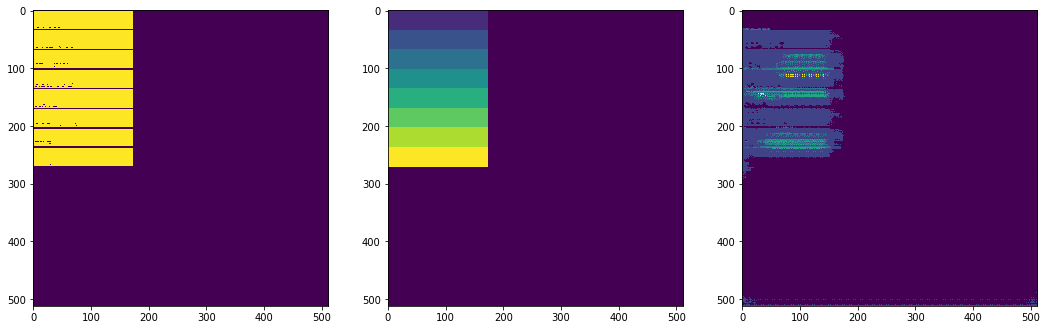

In [0]:
def resize_image(img):
      pos = np.where(img!=0)
      img = img[pos[0].min():pos[0].max(), pos[1].min():pos[1].max()]
      img = cv2.resize(img, (512,512), interpolation=cv2.INTER_NEAREST)
      return img

def predict(model, file_name_img, file_name_mask, input_height, input_width,
            n_classes):
    img_test = cv2.imread(file_name_img, 0)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_height, input_width),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_height, input_width),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    img_test = np.expand_dims(img_test, axis=3)
    img_test[img_test>0.8] = 1
    img_test[img_test<=0.8] = 0

    mask_pred_raw = model.predict(img_test.astype('float32'))
    mask_pred = mask_pred_raw.reshape((input_height, input_width, n_classes)).\
        argmax(axis=2)
    print(img_test[0].shape)
    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0][:,:,0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()
    return mask_pred_raw


mask_pred_raw = predict(model,
                        "dataset_columns/img_column_val/11025_column_1.png",
                        "dataset_columns/img_mask_column_cells_val/11025_table_1.png",
                        input_height, input_width, n_classes)

In [0]:
#model.save(root_path + 'outputs/model_dataset_table_simple_1.h5')